In [ ]:
using Pkg
Pkg.activate(".")
Pkg.Registry.add(RegistrySpec(url="https://github.com/tensor4all/T4ARegistry.git"))
#Pkg.add(["ITensors", "QuanticsGrids", "T4AITensorCompat",  "T4ATensorCI", "T4AQuanticsTCI", "CairoMakie"])
#Pkg.develop(path="../")
#Pkg.develop(path="../../T4ATensorCI.jl")
#Pkg.develop(path="../../T4AQuanticsTCI.jl")
#Pkg.develop(path="../../T4APartitionedMPSs.jl")

  Activating project at `~/projects/JuliaUmbrella/T4APartitionedTT.jl/notebooks`
     Cloning registry from "https://github.com/tensor4all/T4ARegistry.git"
Registry `Tensor4All` already exists in `~/.julia/registries/Tensor4All`.
   Resolving package versions...
    Updating `~/projects/JuliaUmbrella/T4APartitionedTT.jl/notebooks/Project.toml`
  [14428447] ~ T4ATensorCI v0.11.0 `../../T4ATensorCI.jl` ⇒ v0.11.0
    Updating `~/projects/JuliaUmbrella/T4APartitionedTT.jl/notebooks/Manifest.toml`
  [14428447] ~ T4ATensorCI v0.11.0 `../../T4ATensorCI.jl` ⇒ v0.11.0
Precompiling packages...
    439.2 ms  ✓ T4AQuanticsTCI
   1874.7 ms  ✓ T4ATensorCI → TCIT4AITensorCompatConversion
   1882.4 ms  ✓ T4ATensorCI → TCIITensorConversion
  3 dependencies successfully precompiled in 3 seconds. 351 already precompiled.
   Resolving package versions...
     Project No packages added to or removed from `~/projects/JuliaUmbrella/T4APartitionedTT.jl/notebooks/Project.toml`
    Manifest No packages added to

In [14]:
using Revise
using Random
import QuanticsGrids as QG

# Make sure to load T4AITensorCompat first
# before importing other T4A packages
# to activate the ITensor-related extension
import ITensors: ITensors, Index
import T4AITensorCompat as T4AIT
import T4ATensorCI as TCI
import T4ATensorCI
import T4AQuanticsTCI as QTCI
import T4APartitionedTT as T4AP
import T4APartitionedTT: PartitionedTT, SubDomainTT, adaptive_patching, Projector
using CairoMakie
using Test

In [4]:
Random.seed!(1234)

gaussian(x, y) = exp(- ((x-5)^2 + (y-5)^2)) + exp(- ((x+5)^2 + (y+5)^2))

R = 20
xmax = 10.0
grid = QG.DiscretizedGrid{2}(R, (-xmax, -xmax), (xmax, xmax); unfoldingscheme=:interleaved)
tci_tolerance = 1e-7
qtci, ranks, errors = QTCI.quanticscrossinterpolate(Float64, gaussian, grid; verbosity=1, maxbonddim=100, loginterval=1, tolerance=tci_tolerance)

Found 5 global pivots
iteration = 1, rank = 19, error= 8.876018681621926e-8, maxsamplevalue= 1.0, nglobalpivot=5
  Rejected 5 global pivots added in the previous iteration, errors are [5.792176051234912e-9, 9.08263710037516e-9, 5.192334166792545e-10, 4.545009416045964e-8, 3.282693727957309e-8]
Found 0 global pivots
iteration = 2, rank = 38, error= 9.888629684162344e-8, maxsamplevalue= 1.0, nglobalpivot=0
Found 0 global pivots
iteration = 3, rank = 42, error= 9.888629684162344e-8, maxsamplevalue= 1.0, nglobalpivot=0
Found 0 global pivots
iteration = 4, rank = 44, error= 9.888629684162344e-8, maxsamplevalue= 1.0, nglobalpivot=0
Found 0 global pivots
iteration = 5, rank = 43, error= 9.888629684162344e-8, maxsamplevalue= 1.0, nglobalpivot=0
Found 0 global pivots
iteration = 6, rank = 43, error= 9.888629684162344e-8, maxsamplevalue= 1.0, nglobalpivot=0


(T4AQuanticsTCI.QuanticsTensorCI2{Float64}(T4ATensorCI.TensorCI2{Float64} with rank 43, DiscretizedGrid{2}(1048576×1048576 points), T4ATensorCI.CachedFunction{Float64, BitIntegers.UInt256} with 35147 entries), [19, 38, 42, 44, 43, 43], [8.876018681621926e-8, 9.888629684162344e-8, 9.888629684162344e-8, 9.888629684162344e-8, 9.888629684162344e-8, 9.888629684162344e-8])

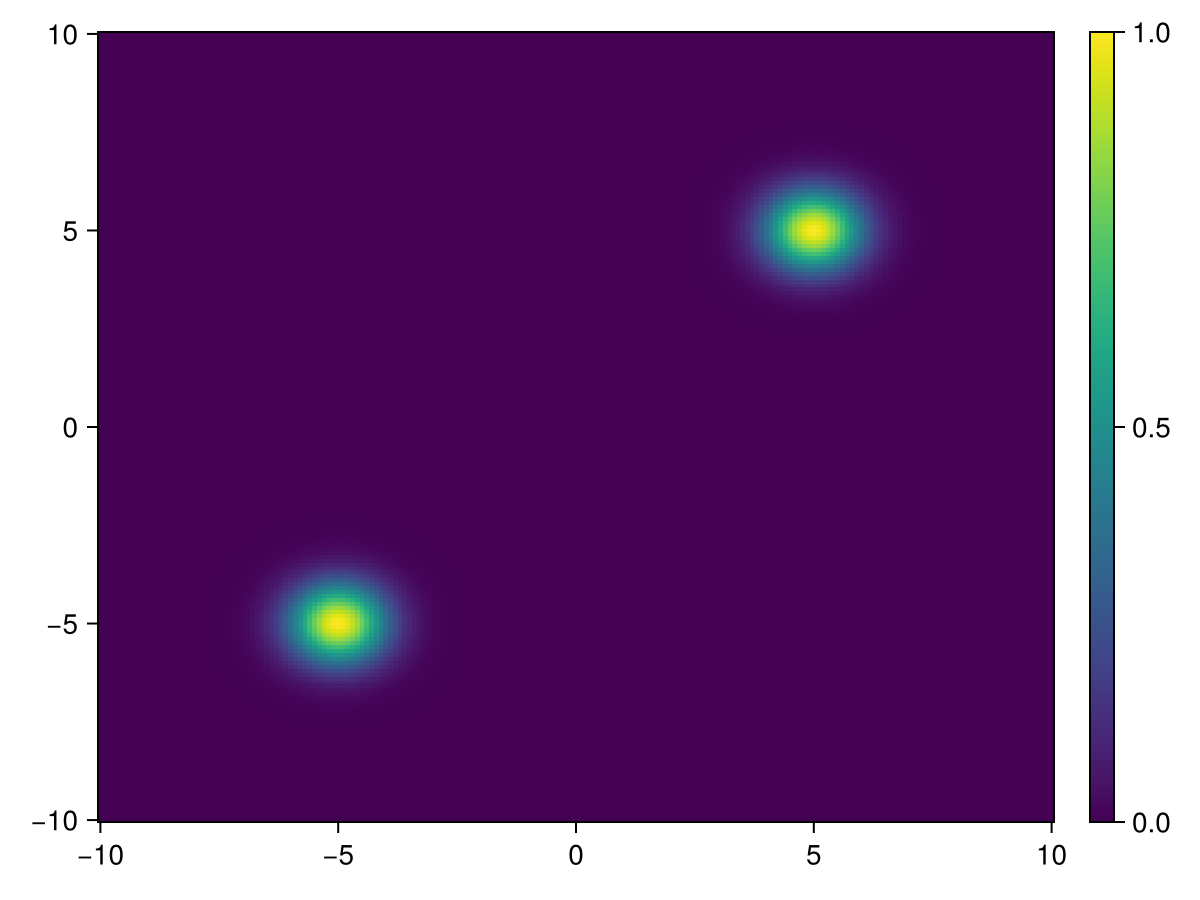

In [5]:
#heatmap(-xmax:0.1:xmax, -xmax:0.1:xmax, gaussian)
fig = Figure()
ax = Axis(fig[1, 1])
hm = heatmap!(ax, -xmax:0.1:xmax, -xmax:0.1:xmax, gaussian)
Colorbar(fig[1, 2], hm)
fig

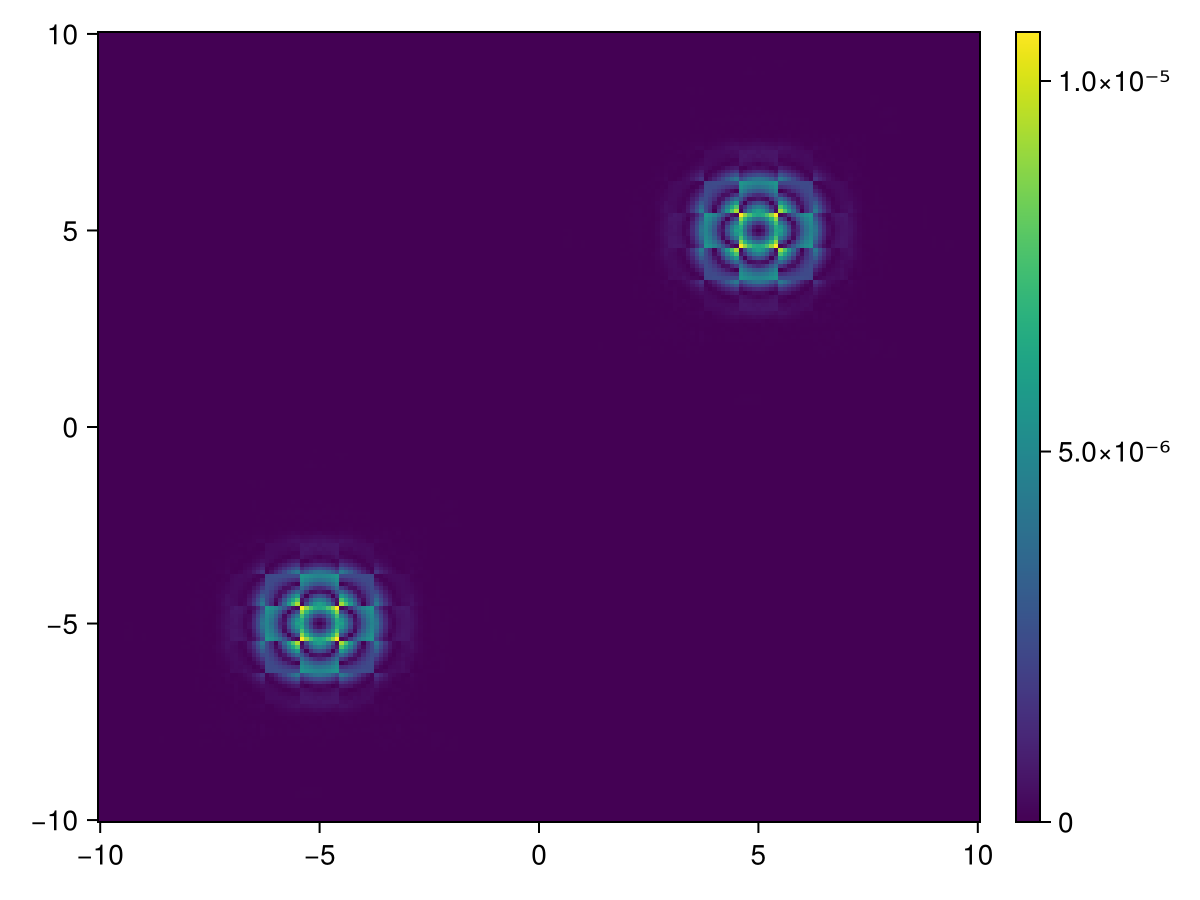

In [6]:
_err(x...) = abs(qtci(QG.origcoord_to_grididx(grid, x)) - gaussian(x...))
fig = Figure()
ax = Axis(fig[1, 1])
hm = heatmap!(ax, -xmax:0.1:xmax, -xmax:0.1:xmax, _err)
Colorbar(fig[1, 2], hm)
fig

In [7]:
# Covert to ITensor-compatible TT format
sitesx = [Index(2, "x=$i") for i in 1:R]
sitesy = [Index(2, "y=$i") for i in 1:R]
all_sites = collect(Iterators.flatten(zip(sitesx, sitesy)))
itt = T4AIT.TensorTrain(TCI.TensorTrain(qtci.tci); sites=all_sites)
;

In [18]:
maxdim_patch = 15
T4AP.adaptive_patching(PartitionedTT(SubDomainTT(deepcopy(itt))), patchorder; maxdim=maxdim_patch, cutoff=cutoff_patch)

UndefVarError: UndefVarError: `apdaptive_patching` not defined in `T4APartitionedTT`
Suggestion: check for spelling errors or missing imports.

In [15]:
# Split into patches
maxdim_patch = 15
cutoff_patch = 0.1 * tci_tolerance^2
patchorder = collect(Iterators.flatten(T4AP.siteinds(itt)))
patched_tt = adaptive_patching(PartitionedTT(SubDomainTT(deepcopy(itt))), patchorder; maxdim=maxdim_patch, cutoff=cutoff_patch)

UndefVarError: UndefVarError: `apdaptive_patching` not defined in `T4APartitionedTT`
Suggestion: check for spelling errors or missing imports.

In [9]:
function bound_idx(p::T4AP.Projector, grid1d, all_sites)::Tuple{Float64,Float64}
    # Count number of bits (R)
    R = QG.grid_Rs(grid1d)[1]
    nbits = R
    
    # Create lower and upper bound MultiIndex
    # Lower bound: unprojected indices = 1, projected indices = projector value
    # Upper bound: unprojected indices = 2, projected indices = projector value
    lower_idx = TCI.MultiIndex(undef, length(all_sites))
    upper_idx = TCI.MultiIndex(undef, length(all_sites))
    
    # Initialize with default values (1 for lower, 2 for upper)
    fill!(lower_idx, 1)
    fill!(upper_idx, 2)
    
    # Set projected indices to their projector values
    # Map projector indices to positions in all_sites
    for (pos, site) in enumerate(all_sites)
        if site in keys(p)
            val = p[site]
            lower_idx[pos] = val
            upper_idx[pos] = val
        end
    end
    
    # Convert quantics indices to original coordinates
    lower_coord = QG.quantics_to_origcoord(grid1d, lower_idx)[1]
    upper_coord = QG.quantics_to_origcoord(grid1d, upper_idx)[1]
    
    return (lower_coord, upper_coord)
end

function patch_bound(p::T4AP.Projector, xmin, xmax, ymin, ymax, all_sites)::NTuple{4, Float64}
    xgrid = QG.DiscretizedGrid{1}(R, xmin, xmax)
    ygrid = QG.DiscretizedGrid{1}(R, ymin, ymax)

    # Separate x and y indices from all_sites
    # For a 2D grid, we need to identify which indices belong to x and which to y
    # The grid structure has R bits for x and R bits for y
    # We'll use the grid's indextable to identify x and y indices
    
    # Get the grid's indextable to understand the structure
    # For a 2D DiscretizedGrid, the indextable shows which site indices correspond to which dimension
    # We need to extract x and y indices based on the grid structure
    
    # For interleaved representation, x and y indices are interleaved
    # Structure: [x_1, y_1, x_2, y_2, ..., x_R, y_R]
    # So we need to extract odd indices for x and even indices for y
    n_total = length(all_sites)
    n_per_dim = n_total ÷ 2
    
    # Split all_sites into x and y parts (interleaved: odd indices = x, even indices = y)
    x_sites = [all_sites[i] for i in 1:2:n_total]  # Odd indices: 1, 3, 5, ...
    y_sites = [all_sites[i] for i in 2:2:n_total]  # Even indices: 2, 4, 6, ...
    
    # Create x and y projectors
    x_proj_dict = Dict{typeof(first(all_sites)), Int}()
    y_proj_dict = Dict{typeof(first(all_sites)), Int}()
    
    for (idx, val) in p
        if idx in x_sites
            x_proj_dict[idx] = val
        elseif idx in y_sites
            y_proj_dict[idx] = val
        end
    end
    
    x_proj = T4AP.Projector(x_proj_dict)
    y_proj = T4AP.Projector(y_proj_dict)
    
    # Get bounds for x and y (bound_idx now returns Float64 coordinates)
    x_lower, x_upper = bound_idx(x_proj, xgrid, x_sites)
    y_lower, y_upper = bound_idx(y_proj, ygrid, y_sites)
    
    return (x_lower, x_upper, y_lower, y_upper)
end

patch_bound (generic function with 1 method)

In [10]:
# Function to draw a box with red lines
function draw_box!(ax, x_lower, x_upper, y_lower, y_upper; color=:red, linewidth=2)
    # Create a closed rectangle: [x1, x2, x2, x1, x1] and [y1, y1, y2, y2, y1]
    x_box = [x_lower, x_upper, x_upper, x_lower, x_lower]
    y_box = [y_lower, y_lower, y_upper, y_upper, y_lower]
    lines!(ax, x_box, y_box, color=color, linewidth=linewidth)
end

_err_patched(x...) = abs(patched_tt(QG.origcoord_to_quantics(grid, x)) - gaussian(x...))
fig = Figure()
ax = Axis(fig[1, 1])
hm = heatmap!(ax, -xmax:0.1:xmax, -xmax:0.1:xmax, _err_patched)
Colorbar(fig[1, 2], hm)

# Draw boxes for all patches
for (proj, subdmps) in patched_tt
    x_lower, x_upper, y_lower, y_upper = patch_bound(proj, -xmax, xmax, -xmax, xmax, all_sites)
    draw_box!(ax, x_lower, x_upper, y_lower, y_upper)
end

fig

UndefVarError: UndefVarError: `patched_tt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [11]:
# Plot the linkdims of patches in a single plot
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Bond position", ylabel="Link dimension", title="Link dimensions of all patches", yscale=log10)

# Get linkdims for each patch
for (patch_idx, (proj, subdmps)) in enumerate(patched_tt)
    tt = T4AIT.TensorTrain(subdmps)
    links = T4AIT.linkinds(tt)
    linkdims = [ITensors.dim(link) for link in links]
    
    # Plot linkdims for this patch
    bond_positions = 1:length(linkdims)
    lines!(ax, bond_positions, linkdims, label="Patch $patch_idx", linewidth=2)
end

#axislegend(ax, position=:rt)
fig

UndefVarError: UndefVarError: `patched_tt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.